# Figure 1 

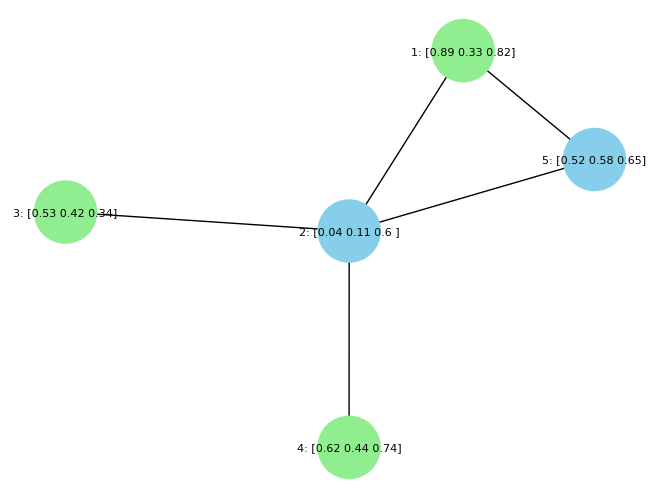

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(6)
G = nx.erdos_renyi_graph(n=5, p=0.5, seed=12)

for node in G.nodes():
    G.nodes[node]['attr'] = np.round(np.random.rand(3),2) # Vector of 3 random attributes


labels = {node: f"{node+1}: {G.nodes[node]['attr']}" for node in G.nodes()}
colors = np.random.choice(['skyblue', 'lightgreen'], size=5)

pos = nx.spring_layout(G, seed=12)
nx.draw(G, pos, with_labels=False, node_color=colors, node_size=2000, font_size=10)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
plt.show()


# Figure 2 

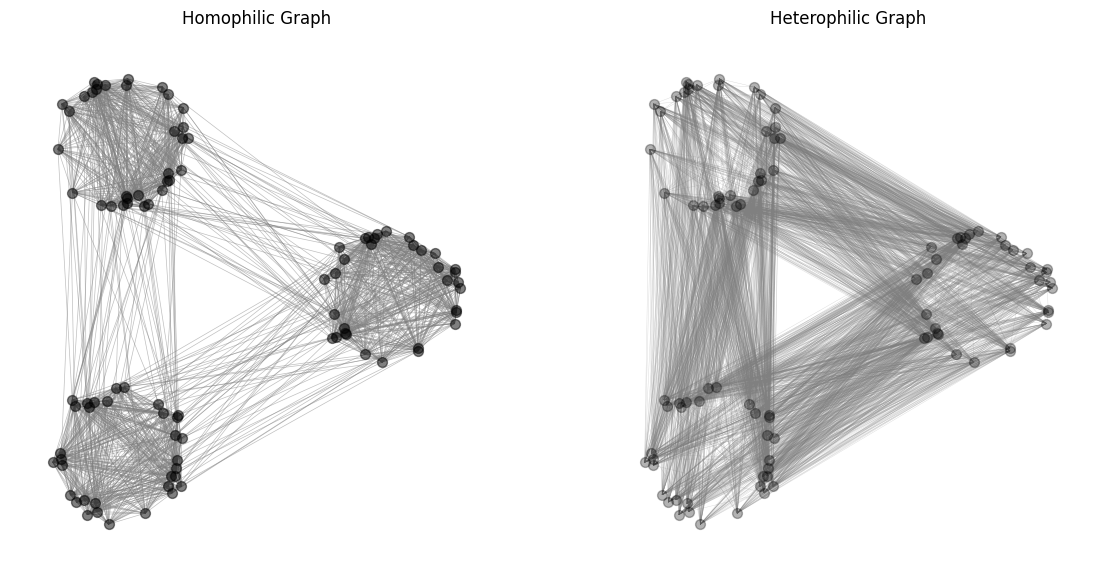

In [66]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

n = 99  
k = 3   
nodes_per_community = n // k

positions = {
    i: (np.cos(2 * np.pi * i / k), np.sin(2 * np.pi * i / k))
    for i in range(k)
}

node_community = {}
for i in range(k):
    for j in range(nodes_per_community):
        node_community[i * nodes_per_community + j] = i

pos = {}
for node, community in node_community.items():
    angle = 2 * np.pi * np.random.rand()  # random angle for within-community variation
    radius = 0.1 * np.random.rand() + 0.3 # random radius for spacing within community
    pos[node] = (positions[community][0] + radius * np.cos(angle),
                 positions[community][1] + radius * np.sin(angle))


G_homophilic = nx.Graph()
for node in range(n):
    G_homophilic.add_node(node)
    for neighbor in range(node + 1, n):
        if node_community[node] == node_community[neighbor]:
            # Higher probability of connecting within the same community
            if np.random.rand() < 0.9:
                G_homophilic.add_edge(node, neighbor)
        else:
            # Lower probability of connecting between communities
            if np.random.rand() < 0.05:
                G_homophilic.add_edge(node, neighbor)


G_heterophilic = nx.Graph()
for node in range(n):
    G_heterophilic.add_node(node)
    for neighbor in range(node + 1, n):
        if node_community[node] != node_community[neighbor]:
            # Higher probability of connecting between communities
            if np.random.rand() < 0.9:
                G_heterophilic.add_edge(node, neighbor)
        else:
            # Lower probability of connecting within the same community
            if np.random.rand() < 0.1:
                G_heterophilic.add_edge(node, neighbor)


fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Homophilic graph
nx.draw(G_homophilic, pos, ax=axs[0], node_size=50, node_color="black", edge_color='gray', width=.5, alpha=.5)
axs[0].set_title('Homophilic Graph')


# Heterophilic graph
nx.draw(G_heterophilic, pos, ax=axs[1], node_size=50, node_color="black", edge_color='gray', width=.3, alpha=.3)
axs[1].set_title('Heterophilic Graph')

plt.show()


In [1]:
from ParametricGraphModels.ADC_SBM import ADC_SBM, from_config
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import config
import pandas as pd

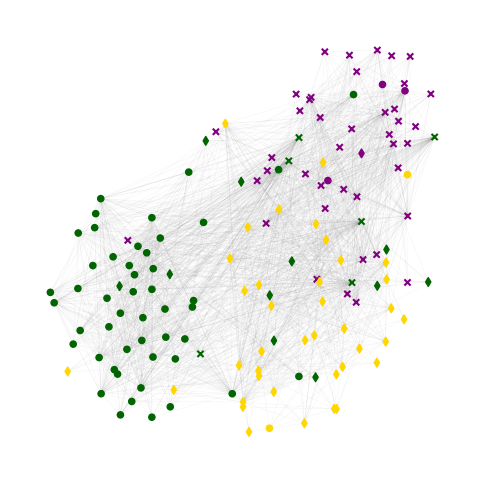

In [17]:
params = config.Scenarios.illustrative_5
graph = from_config(params)
graph.rich_plot_graph(fig_size=(6,6))

     0    1    2
0  370  365  207
1  365  463  175
2  207  175  306
          Y~F       Y~C       F~C
NMI  0.769687  0.567661  0.736554
CV   0.911260  0.787627  0.868243
ARI  0.825566  0.582832  0.714588


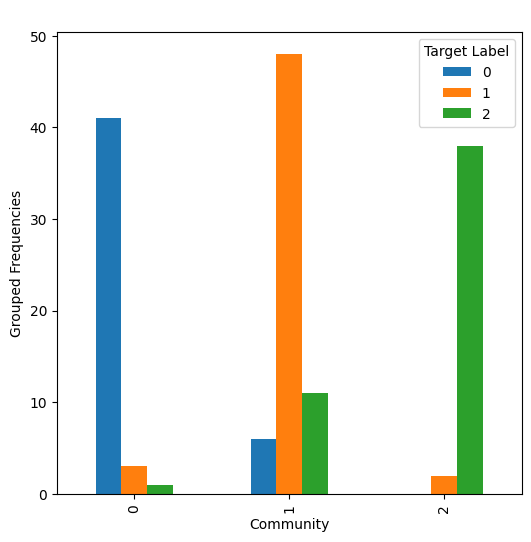

Community
0    0.164938
1    0.417515
2    0.095000
dtype: float64


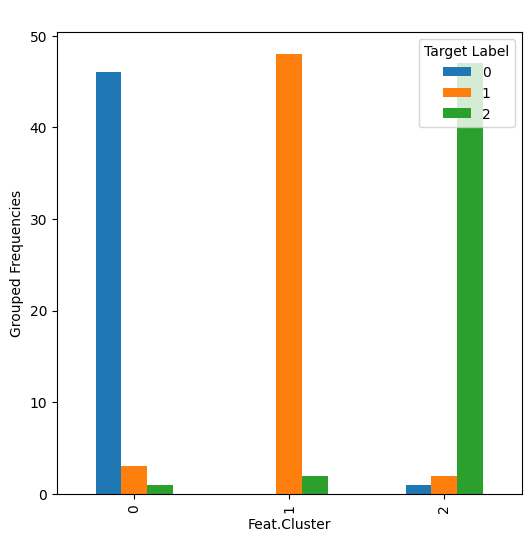

Feat.Cluster
0    0.1496
1    0.0768
2    0.1144
dtype: float64

In [18]:
print(graph.target_edge_counter())
print(graph.label_correlation())
print(graph.purity(fig_size=(6,6), group_by="Community", metric= "gini", plot_it=True))
graph.purity(fig_size=(6,6), group_by="Feat.Cluster", metric= "gini", plot_it=True)